In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

2026-01-19 12:16:59.086870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 12:16:59.094880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768821419.104678  100740 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768821419.107445  100740 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-19 12:16:59.117300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
import random
import numpy as np
import tensorflow as tf

# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass  

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

    print(f"Seeds set to {seed}")


# 🤙Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://raw.githubusercontent.]87helper_functions.py. 100% [=============================>]    3.48K    --.-KB/s87[Files: 1  Bytes: 3.48K [15.42K]8

# 📥Load and Transform Data

In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "raw-img"
walk_through_dir(dataset)

There are 10 directories and 0 images in 'raw-img'.
There are 0 directories and 4863 images in 'raw-img/cane'.
There are 0 directories and 2623 images in 'raw-img/cavallo'.
There are 0 directories and 1446 images in 'raw-img/elefante'.
There are 0 directories and 2112 images in 'raw-img/farfalla'.
There are 0 directories and 3098 images in 'raw-img/gallina'.
There are 0 directories and 1668 images in 'raw-img/gatto'.
There are 0 directories and 1866 images in 'raw-img/mucca'.
There are 0 directories and 1820 images in 'raw-img/pecora'.
There are 0 directories and 4821 images in 'raw-img/ragno'.
There are 0 directories and 1862 images in 'raw-img/scoiattolo'.


# Placing data into a Dataframe
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The first column <b>filepaths</b> contains the file path location of each individual images. The second column <b>labels</b>, on the other hand, contains the class label of the corresponding image from the file path</p>
</div>

In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

/tmp/ipykernel_100740/2361829875.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
/tmp/ipykernel_100740/2361829875.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


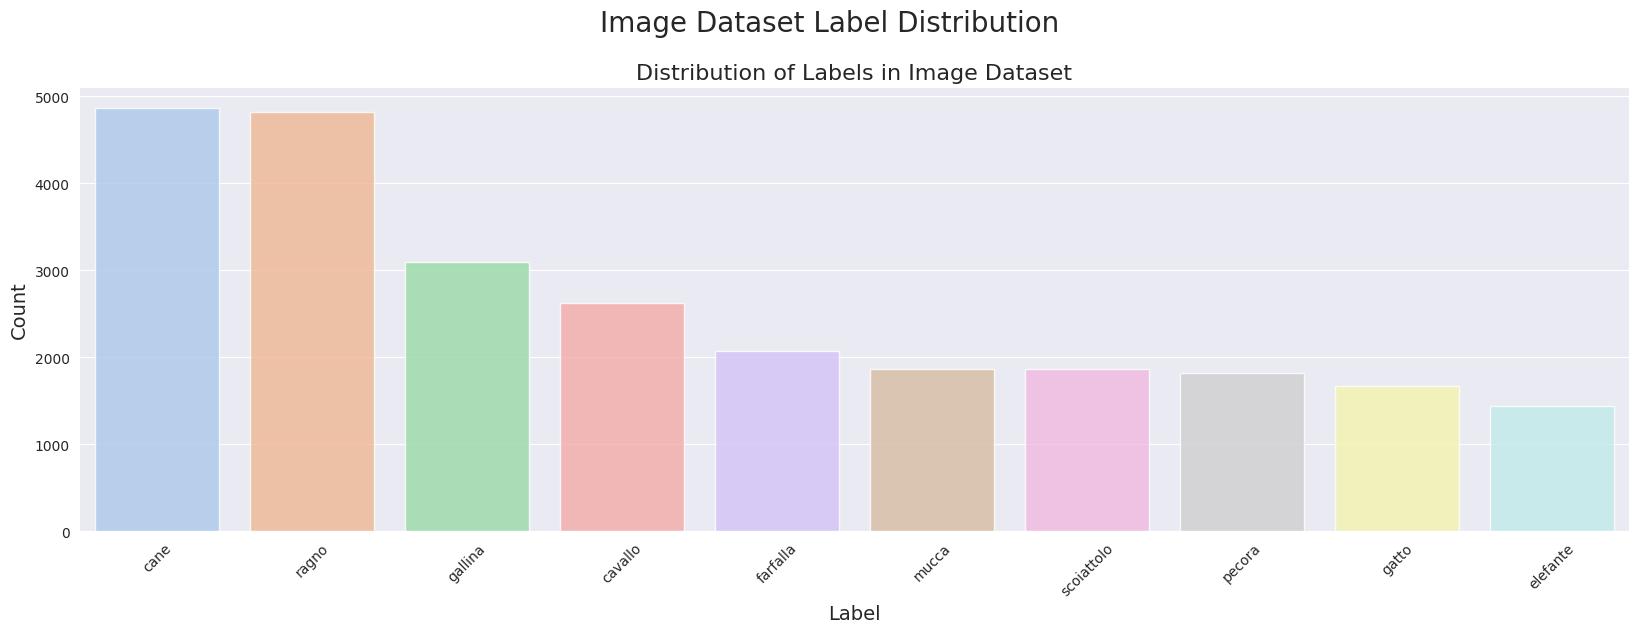

In [8]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

# Visualizing images from the dataset

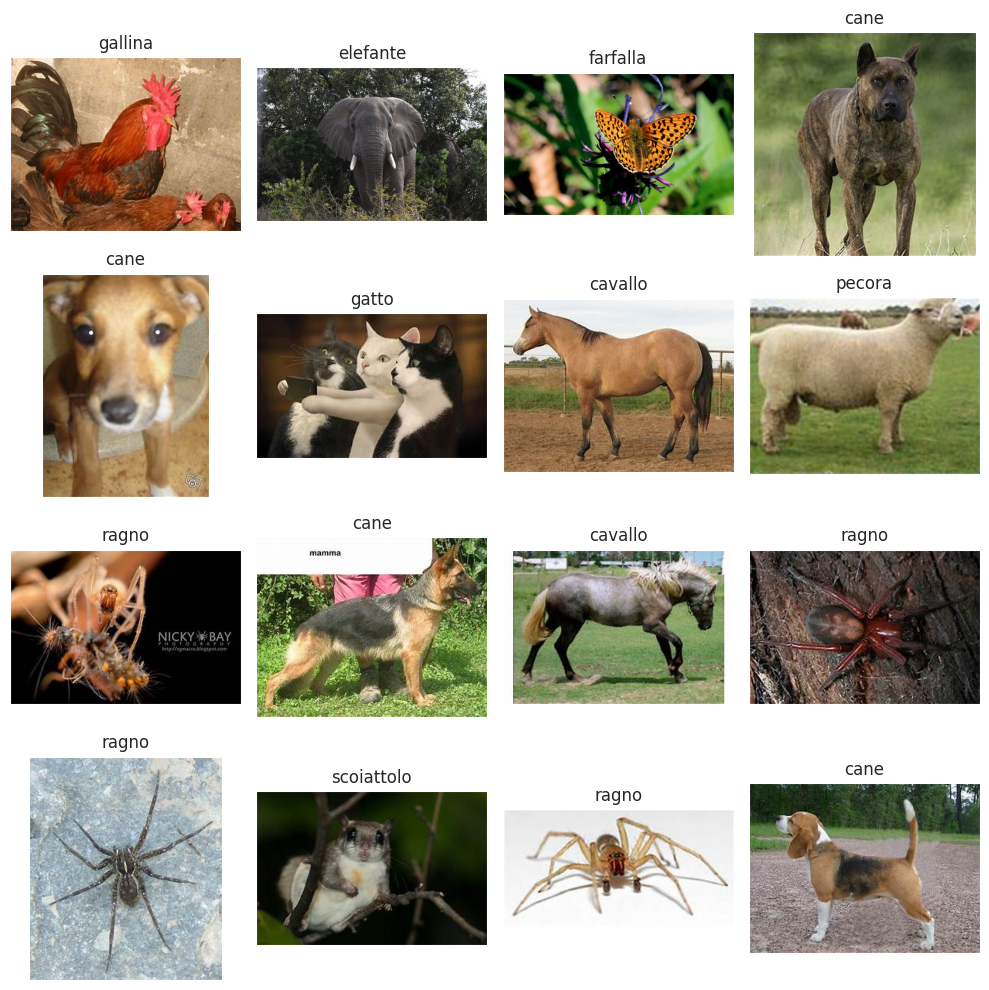

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>
</div>

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 16722 validated image filenames belonging to 10 classes.
Found 4180 validated image filenames belonging to 10 classes.
Found 5226 validated image filenames belonging to 10 classes.


In [13]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

2026-01-19 12:17:02.070324: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Training the model
<div style="background-color:#f2f2f2; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called EfficientNetB7. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

  <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 100<br>
    <strong>Input Shape</strong>: (224, 224, 3)<br>
    <strong>Output layer</strong>: 10
  </p>
</div>




In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [15]:

checkpoint_callback = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Training the model

In [16]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20260119-121704


/home/meriem-mk/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 6961s 13s/step - accuracy: 0.5306 - loss: 1.6008 - val_accuracy: 0.9533 - val_loss: 0.1778 - learning_rate: 1.0000e-04
Epoch 2/30


2026-01-19 14:13:05.966322: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib64/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2026-01-19 14:13:06.000873: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30


/home/meriem-mk/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/home/meriem-mk/.local/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/home/meriem-mk/.local/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


523/523 ━━━━━━━━━━━━━━━━━━━━ 1786s 3s/step - accuracy: 0.9037 - loss: 0.3421 - val_accuracy: 0.9620 - val_loss: 0.1460 - learning_rate: 1.0000e-04
Epoch 4/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 133us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30


2026-01-19 14:42:52.066186: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1764s 3s/step - accuracy: 0.9386 - loss: 0.2271 - val_accuracy: 0.9644 - val_loss: 0.1378 - learning_rate: 1.0000e-04
Epoch 6/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 148us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 1789s 3s/step - accuracy: 0.9430 - loss: 0.1985 - val_accuracy: 0.9684 - val_loss: 0.1271 - learning_rate: 1.0000e-04
Epoch 8/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/30


2026-01-19 15:42:05.358275: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1842s 4s/step - accuracy: 0.9513 - loss: 0.1796 - val_accuracy: 0.9706 - val_loss: 0.1220 - learning_rate: 1.0000e-04
Epoch 10/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 1853s 4s/step - accuracy: 0.9520 - loss: 0.1729 - val_accuracy: 0.9682 - val_loss: 0.1217 - learning_rate: 1.0000e-04
Epoch 12/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 1922s 4s/step - accuracy: 0.9605 - loss: 0.1437 - val_accuracy: 0.9675 - val_loss: 0.1287 - learning_rate: 1.0000e-04
Epoch 14/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 2797s 5s/step - accuracy: 0.9617 - loss: 0.1328 - val_accuracy: 0.9715 - val_loss: 0.1205 - learning_rate: 1.0000e-04
E

2026-01-19 18:02:20.441026: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2273s 4s/step - accuracy: 0.9638 - loss: 0.1305 - val_accuracy: 0.9682 - val_loss: 0.1273 - learning_rate: 1.0000e-04
Epoch 18/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 19/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 1952s 4s/step - accuracy: 0.9674 - loss: 0.1206 - val_accuracy: 0.9699 - val_loss: 0.1235 - learning_rate: 1.0000e-04
Epoch 20/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 21/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 2378s 5s/step - accuracy: 0.9672 - loss: 0.1187 - val_accuracy: 0.9701 - val_loss: 0.1229 - learning_rate: 1.0000e-04
Epoch 22/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 23/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 2536s 5s/step - accuracy: 0.9702 - loss: 0.1060 - val_accuracy: 0.9713 - val_loss: 0.1224 - learning_rate: 2.0000e-05
E

# Model Evaluation
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>
</div>

In [17]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.09852
Test Accuracy: 97.28%


# Visualizing loss curves

# Making predictions on the Test Data

In [18]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

164/164 ━━━━━━━━━━━━━━━━━━━━ 595s 4s/step
The first 5 predictions: ['ragno', 'pecora', 'farfalla', 'cane', 'ragno']


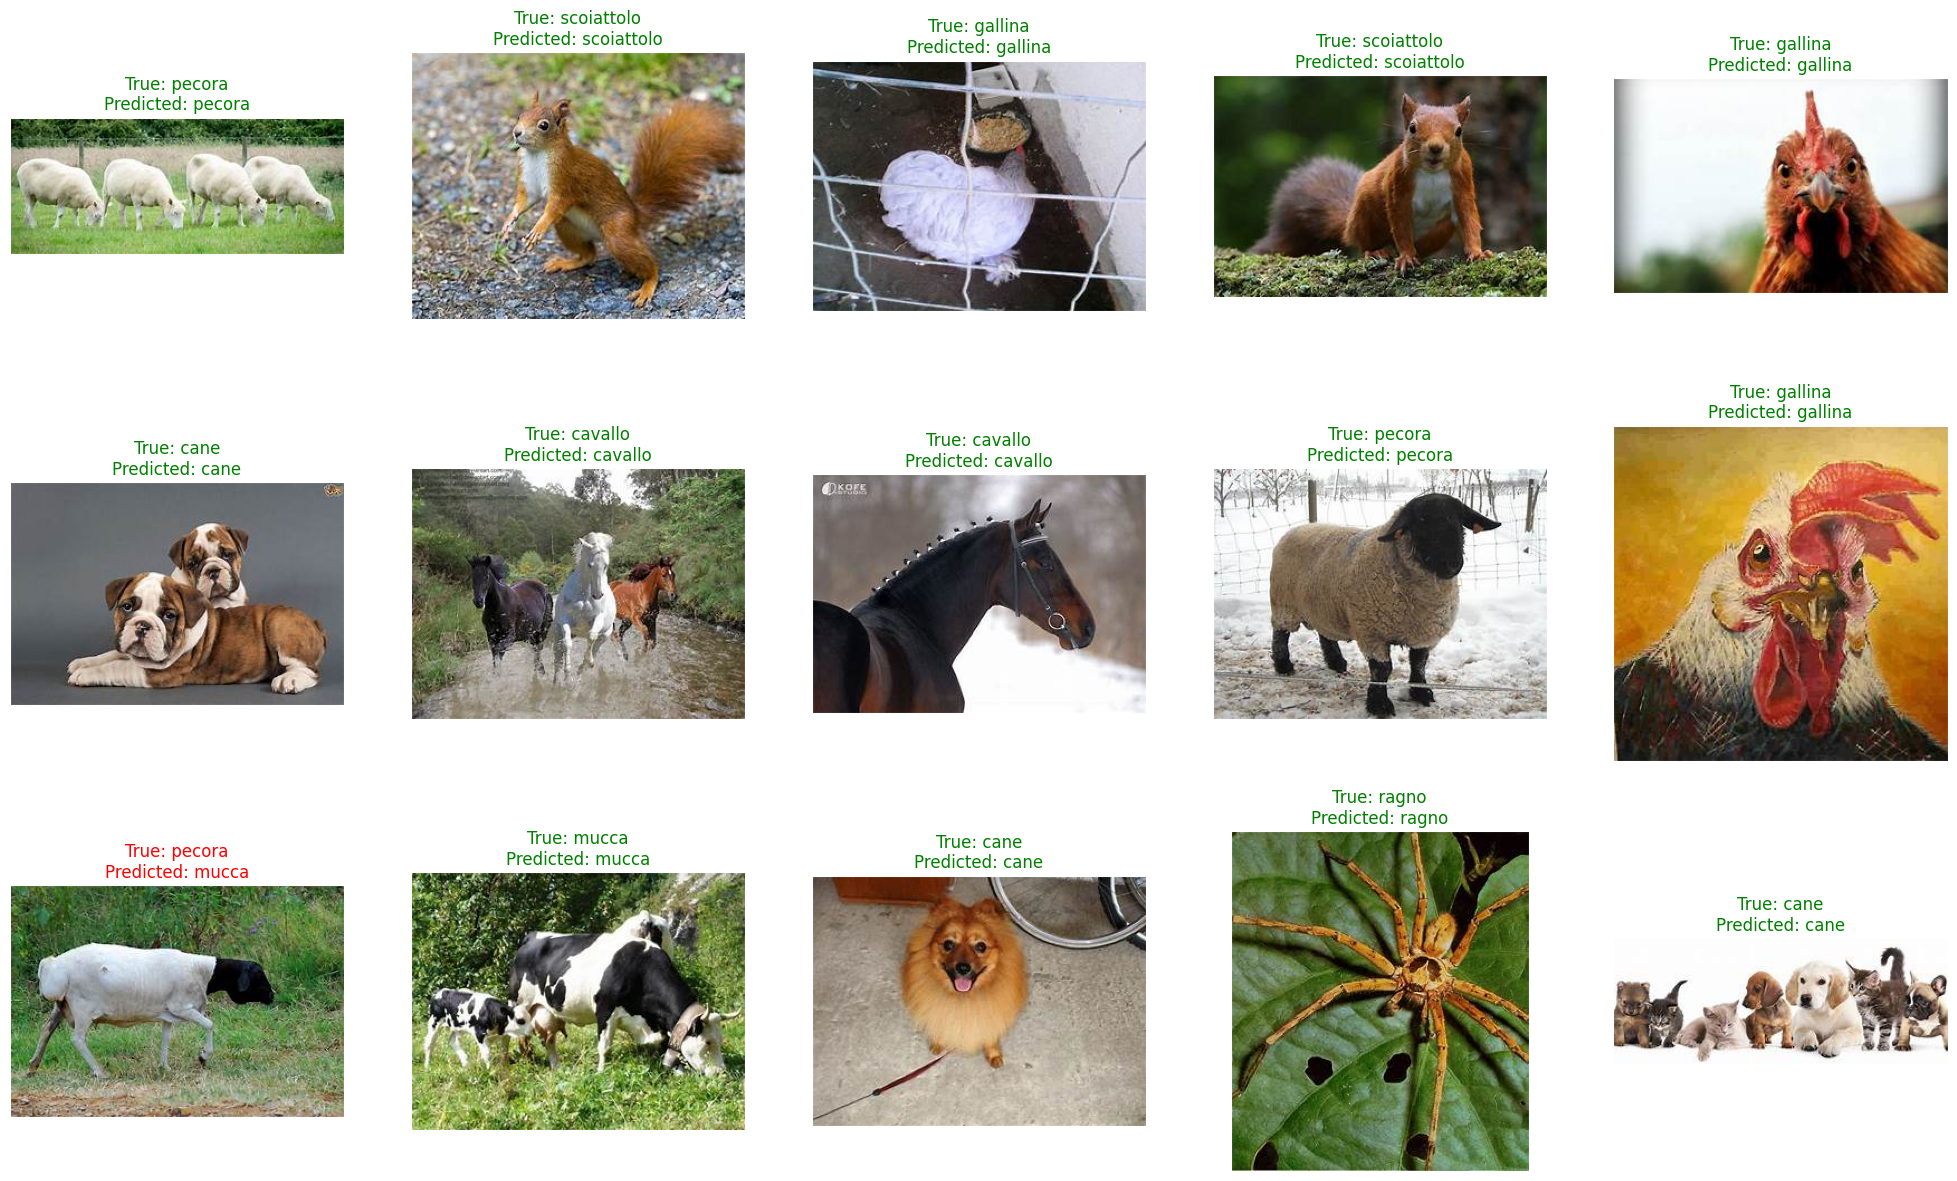

<Figure size 640x480 with 0 Axes>

In [19]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the Classification Reports and Confusion Matrix

<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Confusion matrix</b> and <b>classification report</b> are two important tools used for evaluating the performance of an image classification model.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>
</div>

In [20]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        cane       0.97      0.98      0.98      1017
     cavallo       0.97      0.95      0.96       529
    elefante       0.98      0.99      0.98       300
    farfalla       0.98      0.99      0.98       416
     gallina       0.98      0.99      0.98       614
       gatto       0.95      0.97      0.96       305
       mucca       0.94      0.91      0.92       337
      pecora       0.95      0.93      0.94       374
       ragno       0.99      0.99      0.99       961
  scoiattolo       0.99      0.98      0.98       373

    accuracy                           0.97      5226
   macro avg       0.97      0.97      0.97      5226
weighted avg       0.97      0.97      0.97      5226



In [21]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
cane           0.971680  0.978368  0.975012  1017.000000
cavallo        0.971154  0.954631  0.962822   529.000000
elefante       0.976898  0.986667  0.981758   300.000000
farfalla       0.980861  0.985577  0.983213   416.000000
gallina        0.977492  0.990228  0.983819   614.000000
gatto          0.951768  0.970492  0.961039   305.000000
mucca          0.935976  0.910979  0.923308   337.000000
pecora         0.945799  0.933155  0.939435   374.000000
ragno          0.990644  0.991675  0.991160   961.000000
scoiattolo     0.989160  0.978552  0.983827   373.000000
accuracy       0.972828  0.972828  0.972828     0.972828
macro avg      0.969143  0.968032  0.968539  5226.000000
weighted avg   0.972758  0.972828  0.972756  5226.000000

In [22]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell••••••••••••••••••
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


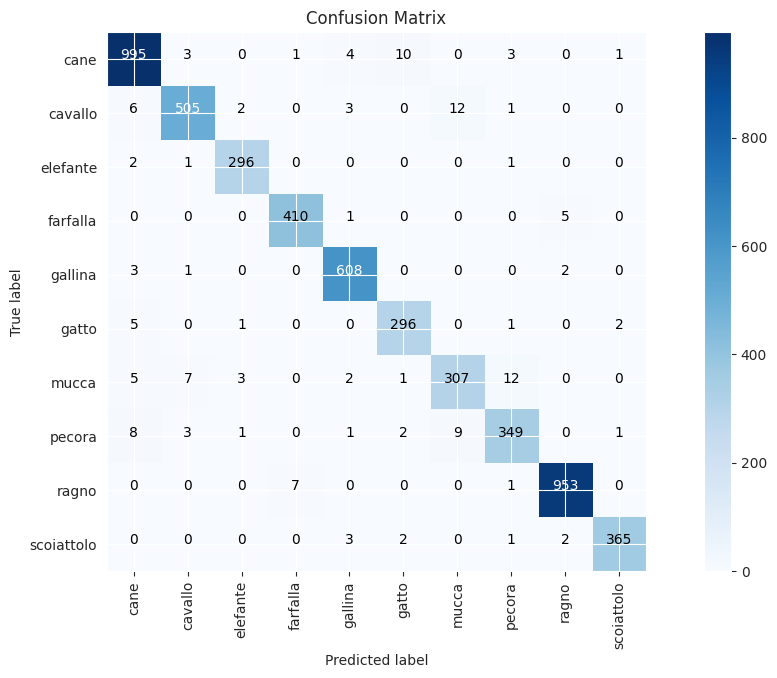

In [23]:
make_confusion_matrix(y_test, pred, list(labels.values()))